In [1]:
#1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

In [5]:
#2. LOAD DATA
train_df = pd.read_csv("Data/train_values.csv")
labels_df = pd.read_csv("Data/train_labels.csv")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {labels_df.shape}")

Train shape: (260601, 39)
Test shape: (260601, 2)


In [6]:
# Merge train features with labels on building_id to create full train set
full_train_df = train_df.merge(labels_df, on='building_id', how='inner')

# Separate features and target
X_train_full = full_train_df.drop(columns=['building_id', 'damage_grade'])
y_train_full = full_train_df['damage_grade']

# Adjust labels to start from 0 for XGBoost compatibility (damage_grade 1,2,3 -> 0,1,2)
y_train_full = y_train_full - 1

# Define columns
categorical_cols = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']  # Added geo_level as categorical
numerical_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage'] + [col for col in X_train_full.columns if col.startswith('has_secondary_use')]

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    if col in X_train_full.columns:
        le = LabelEncoder()
        X_train_full[col] = le.fit_transform(X_train_full[col])
        label_encoders[col] = le

# Split train into train and validation sets for evaluation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Outlier Removal using IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filter rows within bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


In [7]:

numerical_cols_for_outlier_removal = ['age', 'area_percentage', 'height_percentage', 'count_floors_pre_eq']
print("Removing outliers using IQR method...")
print(f"X_train shape before outlier removal: {X_train.shape}")
X_train = remove_outliers_iqr(X_train, numerical_cols_for_outlier_removal)
print(f"X_train shape after outlier removal: {X_train.shape}")

Removing outliers using IQR method...
X_train shape before outlier removal: (208480, 38)
X_train shape after outlier removal: (115886, 38)


In [8]:
# Align y_train with the filtered X_train
y_train = y_train.loc[X_train.index]
# Scale numerical features (fit on X_train, transform both)
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
# Adjust y_val back to original for evaluation
y_val_original = y_val + 1

# Model 1: Logistic Regression (should see potential accuracy improvement due to outlier removal)
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_val_pred_log = log_reg.predict(X_val) + 1  # Adjust back
print("Logistic Regression Validation Accuracy:", accuracy_score(y_val_original, y_val_pred_log))
print("Logistic Regression F1-Score (Macro):", f1_score(y_val_original, y_val_pred_log, average='macro'))
print("Logistic Regression Classification Report:\n", classification_report(y_val_original, y_val_pred_log))


# Model 2: Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_val_pred_dt = dt_model.predict(X_val) + 1
print("Decision Tree Validation Accuracy:", accuracy_score(y_val_original, y_val_pred_dt))
print("Decision Tree F1-Score (Macro):", f1_score(y_val_original, y_val_pred_dt, average='macro'))
print("Decision Tree Classification Report:\n", classification_report(y_val_original, y_val_pred_dt))

# Model 3: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_val_pred_rf = rf_model.predict(X_val) + 1
print("Random Forest Validation Accuracy:", accuracy_score(y_val_original, y_val_pred_rf))
print("Random Forest F1-Score (Macro):", f1_score(y_val_original, y_val_pred_rf, average='macro'))
print("Random Forest Classification Report:\n", classification_report(y_val_original, y_val_pred_rf))

# Model 4: XGBoost with basic tuning
xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42))
])
param_grid = {'xgb__n_estimators': [50, 100], 'xgb__max_depth': [3, 6]}
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)
xgb_model = grid_search.best_estimator_
y_val_pred_xgb = xgb_model.predict(X_val) + 1
print("XGBoost Validation Accuracy:", accuracy_score(y_val_original, y_val_pred_xgb))
print("XGBoost F1-Score (Macro):", f1_score(y_val_original, y_val_pred_xgb, average='macro'))
print("XGBoost Classification Report:\n", classification_report(y_val_original, y_val_pred_xgb))
print("All models trained and evaluated on validation set.")


Logistic Regression Validation Accuracy: 0.571554651675908
Logistic Regression F1-Score (Macro): 0.33691181330553005
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           1       0.55      0.16      0.24      5025
           2       0.58      0.96      0.72     29652
           3       0.42      0.03      0.05     17444

    accuracy                           0.57     52121
   macro avg       0.51      0.38      0.34     52121
weighted avg       0.52      0.57      0.45     52121

Decision Tree Validation Accuracy: 0.6279426718597111
Decision Tree F1-Score (Macro): 0.5709102514046033
Decision Tree Classification Report:
               precision    recall  f1-score   support

           1       0.44      0.44      0.44      5025
           2       0.69      0.68      0.68     29652
           3       0.58      0.60      0.59     17444

    accuracy                           0.63     52121
   macro avg       0.57      0.57      0.57

In [9]:
# Feature Importance Table
feature_names = X_train.columns.tolist()
log_reg_importance = abs(log_reg.coef_).mean(axis=0)
dt_importance = dt_model.feature_importances_
rf_importance = rf_model.feature_importances_
xgb_importance = xgb_model.named_steps['xgb'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Logistic Regression': log_reg_importance,
    'Decision Tree': dt_importance,
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance
})
importance_df['Average Importance'] = importance_df[['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']].mean(axis=1)
importance_df = importance_df.sort_values(by='Average Importance', ascending=False)
print("Feature Importance Table (sorted by average importance):")
print(importance_df)

Feature Importance Table (sorted by average importance):
                                   Feature  Logistic Regression  \
4                                      age             0.266149   
15     has_superstructure_mud_mortar_stone             0.285940   
0                           geo_level_1_id             0.018145   
2                           geo_level_3_id             0.000009   
5                          area_percentage             0.065804   
1                           geo_level_2_id             0.000017   
8                          foundation_type             0.187619   
25                  legal_ownership_status             0.211004   
12                                position             0.186736   
20               has_superstructure_timber             0.142289   
9                                roof_type             0.102125   
26                          count_families             0.117514   
10                       ground_floor_type             0.100499   
11   

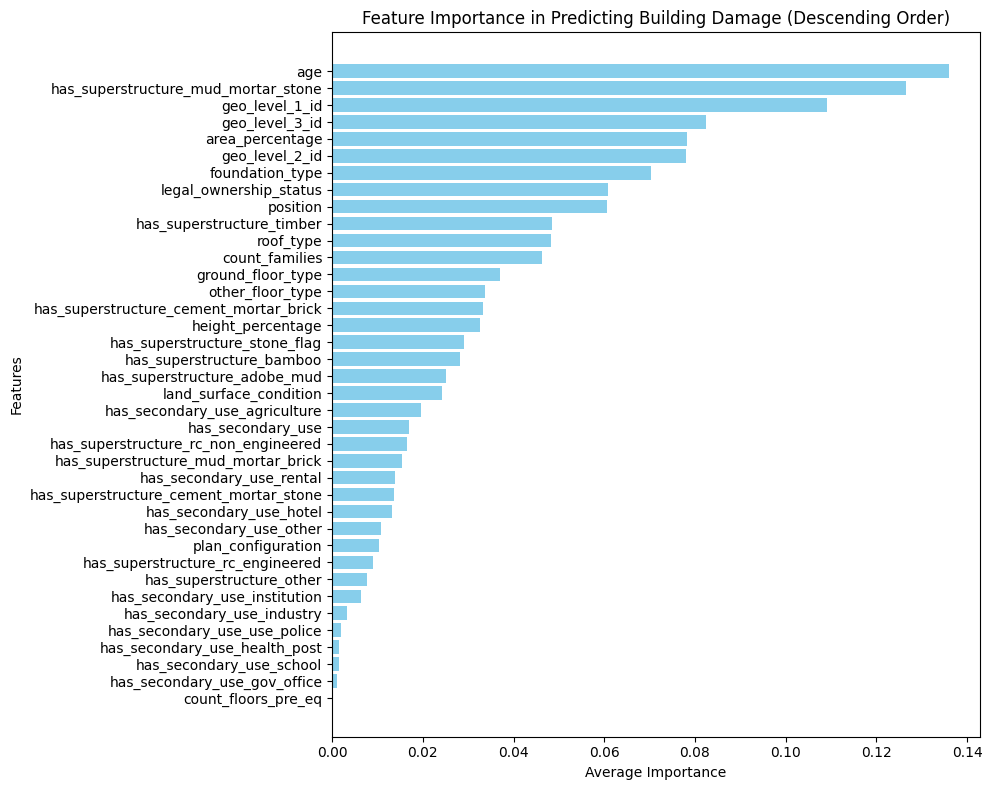


Prediction Table (using Random Forest on full training set):
   building_id  damage_grade
0       802906             3
1        28830             2
2        94947             3
3       590882             2
4       201944             3


In [98]:
# Plot the descending bar graph for average importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Average Importance'], color='skyblue')
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Predicting Building Damage (Descending Order)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Prediction Table: Predict on the full training set and create building_id + predicted damage_grade
# Retrain on full data for final predictions 
X_train_full[numerical_cols] = scaler.fit_transform(X_train_full[numerical_cols])  
full_pred_rf = rf_model.fit(X_train_full, y_train_full).predict(X_train_full) + 1
prediction_df = pd.DataFrame({
    'building_id': full_train_df['building_id'],
    'damage_grade': full_pred_rf
})
print("\nPrediction Table (using Random Forest on full training set):")
print(prediction_df.head())
importance_df.to_csv('feature_importance.csv', index=False)
prediction_df.to_csv('predictions.csv', index=False)



XGBoost Feature Importance Table (sorted descending):
                                   Feature  XGBoost Importance
15     has_superstructure_mud_mortar_stone            0.191542
0                           geo_level_1_id            0.111270
8                          foundation_type            0.061487
14            has_superstructure_adobe_mud            0.054695
16           has_superstructure_stone_flag            0.050158
19  has_superstructure_cement_mortar_brick            0.043836
9                                roof_type            0.040381
18     has_superstructure_mud_mortar_brick            0.035813
11                        other_floor_type            0.029566
20               has_superstructure_timber            0.027790
1                           geo_level_2_id            0.027107
37                 has_secondary_use_other            0.023913
17  has_superstructure_cement_mortar_stone            0.019767
10                       ground_floor_type            0.019513


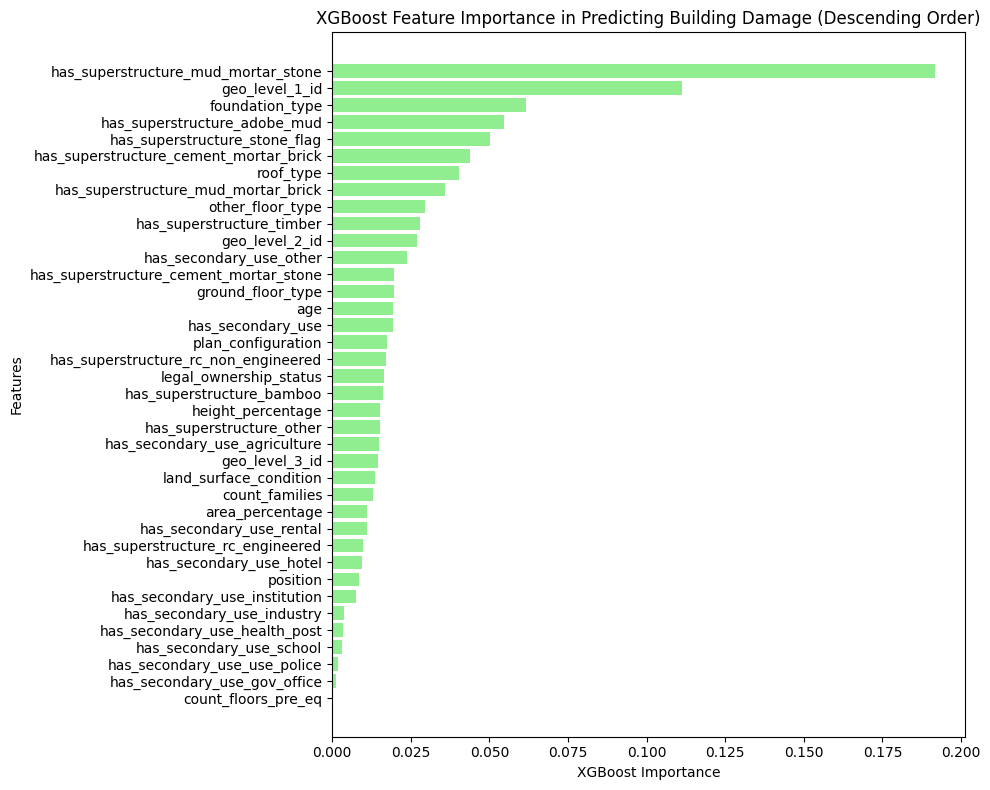

In [99]:
# XGBoost Specific Feature Importance Table
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'XGBoost Importance': xgb_importance
}).sort_values(by='XGBoost Importance', ascending=False)
print("\nXGBoost Feature Importance Table (sorted descending):")
print(xgb_importance_df)
plt.figure(figsize=(10, 8))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['XGBoost Importance'], color='lightgreen')
plt.xlabel('XGBoost Importance')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance in Predicting Building Damage (Descending Order)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [100]:
# Cross-Validation Evaluation 
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "Logistic Regression": log_reg,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}
for name, model in models.items():
    print(f"Evaluating {name}...")
    scores_acc = cross_val_score(model, X_train_full, y_train_full, cv=cv_strat, scoring='accuracy', n_jobs=-1)
    scores_f1 = cross_val_score(model, X_train_full, y_train_full, cv=cv_strat, scoring='f1_macro', n_jobs=-1)
    print(f"  Accuracy Scores: {scores_acc}, Mean: {scores_acc.mean():.4f}, Std: {scores_acc.std():.4f}")
    print(f"  F1-Macro Scores: {scores_f1}, Mean: {scores_f1.mean():.4f}, Std: {scores_f1.std():.4f}\n")


Evaluating Logistic Regression...
  Accuracy Scores: [0.57048023 0.56820798 0.56655794 0.58240599 0.57653492], Mean: 0.5728, Std: 0.0059
  F1-Macro Scores: [0.38664449 0.38356824 0.38457049 0.41878979 0.38943889], Mean: 0.3926, Std: 0.0132

Evaluating Decision Tree...
  Accuracy Scores: [0.65537883 0.65794321 0.65690714 0.65782809 0.65706063], Mean: 0.6570, Std: 0.0009
  F1-Macro Scores: [0.60487337 0.60745067 0.60506762 0.6084755  0.61066241], Mean: 0.6073, Std: 0.0022

Evaluating Random Forest...
  Accuracy Scores: [0.71834769 0.72022256 0.71953185 0.72183423 0.71891788], Mean: 0.7198, Std: 0.0012
  F1-Macro Scores: [0.66119085 0.66260328 0.66097992 0.66513439 0.66229228], Mean: 0.6624, Std: 0.0015

Evaluating XGBoost...
  Accuracy Scores: [0.7249669  0.7274175  0.72507675 0.72726401 0.72588258], Mean: 0.7261, Std: 0.0010
  F1-Macro Scores: [0.66170226 0.66369846 0.65955316 0.66583494 0.66367399], Mean: 0.6629, Std: 0.0021



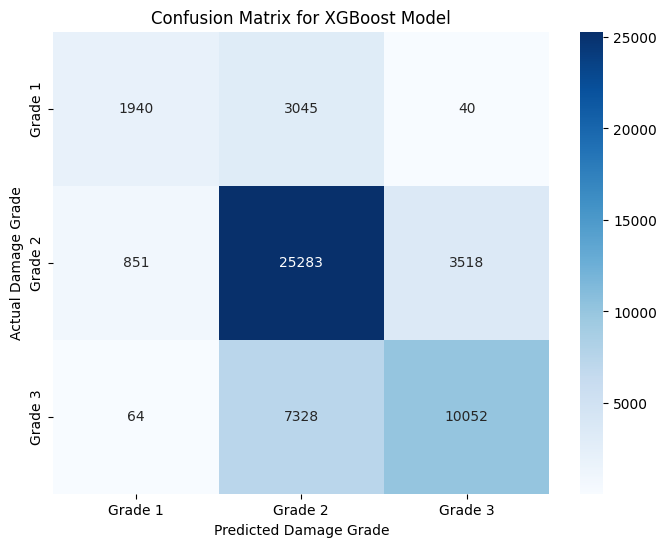

In [101]:
# Confusion Matrix for XGBoost
cm = confusion_matrix(y_val_original, y_val_pred_xgb)
labels = ['Grade 1', 'Grade 2', 'Grade 3']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted Damage Grade')
plt.ylabel('Actual Damage Grade')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

try:
    # Load train data (no test available)
    train_df = pd.read_csv("Data/train_values.csv")
    labels_df = pd.read_csv("Data/train_labels.csv")
    print("Train data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Please check file paths.")
    exit()

# Merge train features with labels
full_train_df = train_df.merge(labels_df, on='building_id', how='inner')

# Separate features and target
X_full = full_train_df.drop(columns=['building_id', 'damage_grade'])
y_full = full_train_df['damage_grade'] - 1  # Adjust to 0-2 for model

# Define columns
categorical_cols = ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'legal_ownership_status', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage'] + [col for col in X_full.columns if col.startswith('has_secondary_use')]

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    if col in X_full.columns:
        le = LabelEncoder()
        X_full[col] = le.fit_transform(X_full[col])
        label_encoders[col] = le

# Split for training (use a portion for model training, predict on full)
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.3, random_state=42, stratify=y_full)  # Temp split for training

# Outlier removal on train (IQR)
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_cols_for_outlier_removal = ['age', 'area_percentage', 'height_percentage', 'count_floors_pre_eq']
X_train = remove_outliers_iqr(X_train, numerical_cols_for_outlier_removal)
y_train = y_train.loc[X_train.index]

# Scale numerical features (fit on train, transform full)
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_full[numerical_cols] = scaler.transform(X_full[numerical_cols])

# Train XGBoost on subset
xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42))
])
param_grid = {'xgb__n_estimators': [50, 100], 'xgb__max_depth': [3, 6]}
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

# Predict on full train set
full_predictions = best_xgb_model.predict(X_full) + 1  # Adjust back to 1-3

# Create final DataFrame for CSV
final_df = pd.DataFrame({
    'building_id': full_train_df['building_id'],
    'actual_damage_grade': full_train_df['damage_grade'],  # Actual for comparison
    'predicted_damage_grade': full_predictions,
    'age': X_full['age'],  # For age-based visualizations
    'geo_level_1_id': X_full['geo_level_1_id'],  # For location-based maps/charts
    'geo_level_2_id': X_full['geo_level_2_id'],
    'geo_level_3_id': X_full['geo_level_3_id'],
    'foundation_type': X_full['foundation_type'],  # For structural insights
})

# Save to CSV
final_df.to_csv('final_predictions_for_dashboard.csv', index=False)
print("Final CSV saved as 'final_predictions_for_dashboard_new.csv'")
print(final_df.head())  # Preview first 5 rows
